## Import libraries

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import warnings
import os
import glob
import cv2
import keras
import math

from matplotlib.pyplot import imshow
from keras.preprocessing import image
from keras import applications
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing.image import ImageDataGenerator
from glob import glob
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import Model
from keras import layers
from keras.layers import Input,Dense,Activation,ZeroPadding2D,BatchNormalization,Flatten,Conv2D
from keras.layers import AveragePooling2D,GlobalAveragePooling2D,GlobalMaxPool2D,MaxPooling2D,MaxPool2D,Dropout
from keras.models import Model, Sequential
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications import EfficientNetB0
from keras.applications.xception import Xception

warnings.simplefilter('ignore')

## Connect to google drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Change the patha and Get the list of directory on drive path

In [3]:
# Change to the directory of interest
path = '/content/drive/MyDrive/horse-or-human'
os.chdir(path)

# List files in the directory
os.listdir(path)

['validation', 'train']

## Make glob file

In [ ]:
train=glob.glob('//content//drive//MyDrive//horse-or-human//train//*')
train

['//content//drive//MyDrive//horse-or-human//train/horses',
 '//content//drive//MyDrive//horse-or-human//train/humans']

In [ ]:
glob.glob('//content//drive//MyDrive//horse-or-human//train/horses//*')

['//content//drive//MyDrive//horse-or-human//train/horses/horse01-5.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-0.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-4.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-6.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-8.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-7.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-3.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-1.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse01-2.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse03-7.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse02-8.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse03-4.png',
 '//content//drive//MyDrive//horse-or-human//train/horses/horse02-6.png',
 '//content//drive//MyDrive//horse-or-

## Check Image on train data

(300, 300, 3)


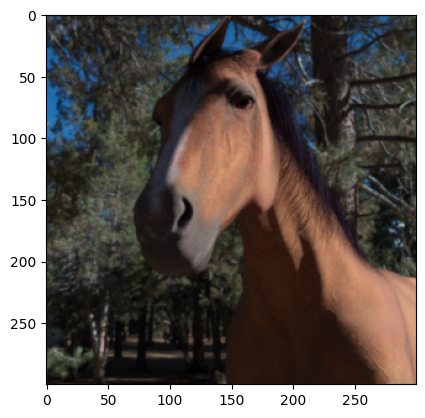

In [ ]:
img = cv2.imread('//content//drive//MyDrive//horse-or-human//train/horses/horse50-4.png')
print(img.shape)
img1 = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img1)

## Get the train classes

In [ ]:
train_class=os.listdir('//content//drive//MyDrive//horse-or-human//train//')
train_class

['horses', 'humans']

## Get the count of data as per class

In [ ]:
count_dict1 = {}
img_dict1 = {}

# Loop through classes
for cls in train_class:  # Assuming class_names contains the list of dog classes
    image_path = glob.glob(f'//content//drive//MyDrive//horse-or-human//train//{cls}//*')
    count_dict1[cls] = len(image_path)

    if image_path:  # Check if image_path is not empty
        img_dict1[cls] = tf.keras.utils.load_img(random.choice(image_path))
count_dict1

{'horses': 500, 'humans': 527}

In [ ]:
df1 = pd.DataFrame(data={'label':count_dict1.keys(),'count':count_dict1.values()})

In [ ]:
df1

,label,count
0,horses,500
1,humans,527


## Visualize the count as per class

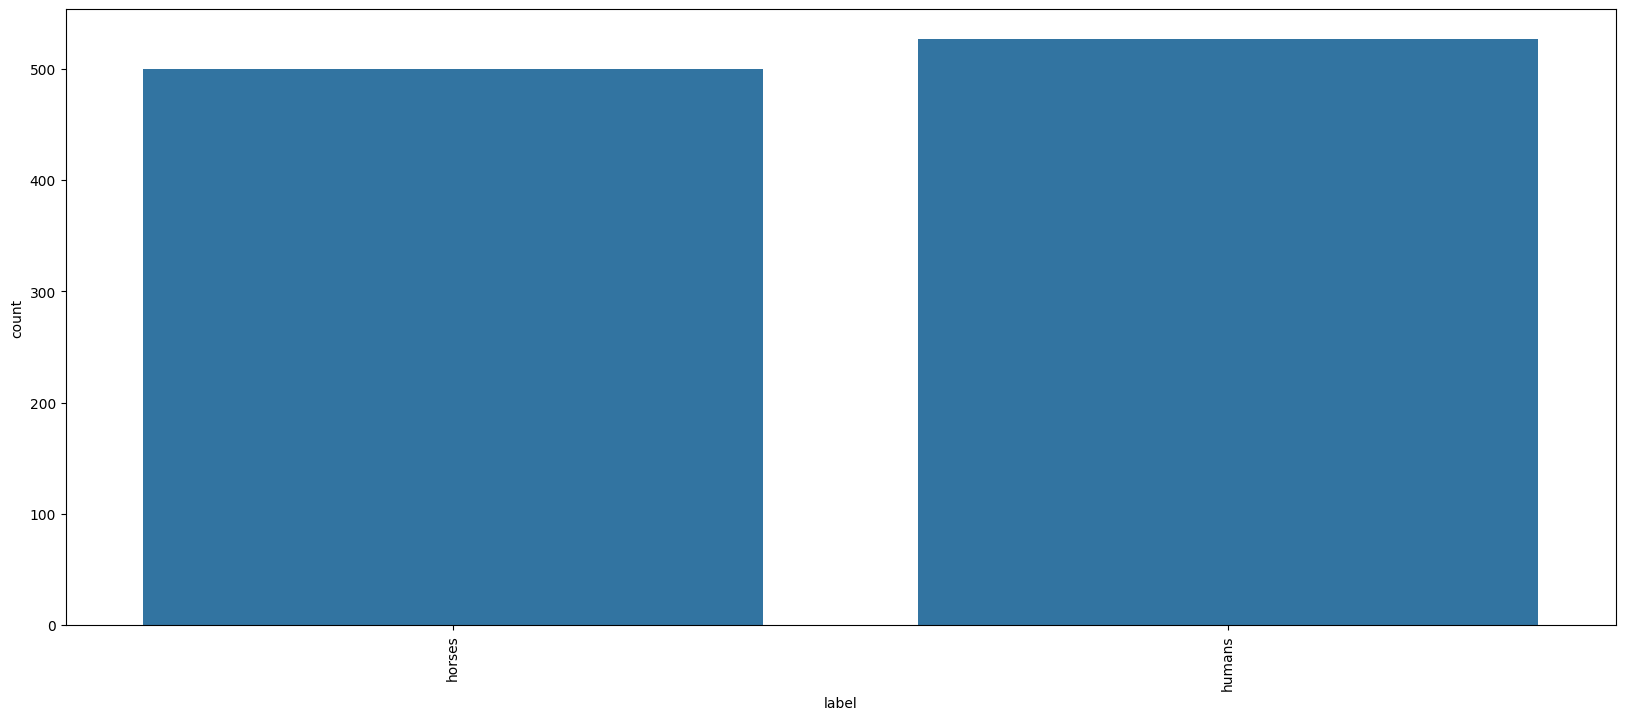

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x='label',y='count',data=df1)
plt.xticks(rotation=90)
plt.show()

## Visualize the image as per class

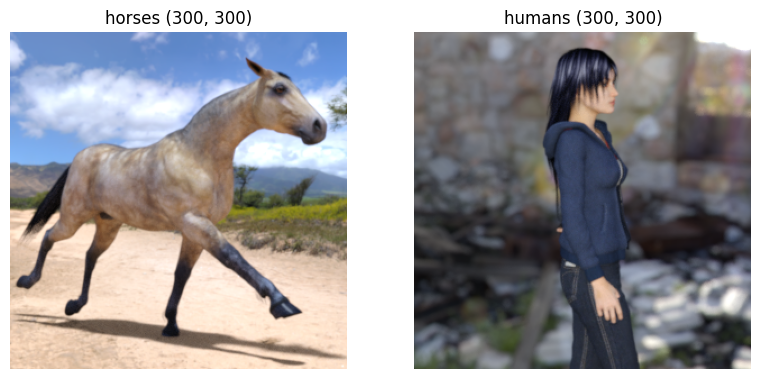

In [ ]:
num_items = len(img_dict1)
num_cols = 4
num_rows = math.ceil(num_items / num_cols)

plt.figure(figsize=(20, 5 * num_rows))  # Adjust the figure size based on the number of rows

for id, (label, img) in enumerate(img_dict1.items()):
    plt.subplot(num_rows, num_cols, id + 1)
    plt.imshow(img)
    plt.title(f"{label} {img.size}")
    plt.axis('off')

## Get the list of test classes

In [ ]:
valid_dir=os.listdir('//content//drive//MyDrive//horse-or-human//validation')
valid_dir

['humans', 'horses']

In [ ]:
img_dict={}
count_dict={}
for cls in valid_dir:
    img_path=glob.glob(f'//content//drive//MyDrive//horse-or-human//validation//{cls}/*')
    count_dict[cls]=len(img_path)
    if img_path:
        img_dict[cls]=tf.keras.utils.load_img(random.choice(img_path))
count_dict

{'humans': 128, 'horses': 128}

## Visualize the image as per class on test

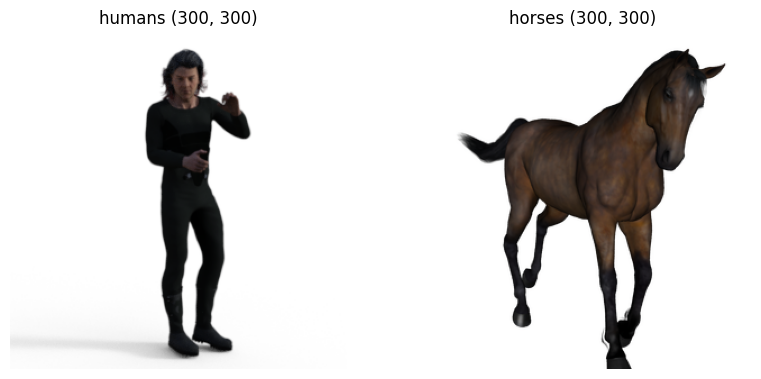

In [ ]:
num_items=len(img_dict)
num_cols=4
num_rows=math.ceil(num_items/num_cols)
plt.figure(figsize=(20, 5* num_rows))
for id ,(label,img) in enumerate (img_dict.items()):
    plt.subplot(num_rows,num_cols, id + 1)
    plt.imshow(img)
    plt.title(f'{label} {img.size}')
    plt.axis('off')

## Data Preprecessing

In [ ]:
train_data=tf.keras.utils.image_dataset_from_directory('//content//drive//MyDrive//horse-or-human//train',label_mode='categorical',shuffle=False)
validation_data=tf.keras.utils.image_dataset_from_directory('//content//drive//MyDrive//horse-or-human//validation',label_mode='categorical',shuffle=False)

Found 1027 files belonging to 2 classes.
Found 256 files belonging to 2 classes.


In [ ]:
batch_size = 40
# this is the augmentation configuration we will use for training
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                1./255,
                rotation_range=40,
                width_shift_range=0.2,
                height_shift_range=0.2,
                zoom_range=0.2,
                horizontal_flip=True)

# batches of augmented image data
train_generator = train_datagen.flow_from_directory(
        '//content//drive//MyDrive//horse-or-human//train',  # this is the target directory
        target_size = (150,150),
        batch_size = 20,
        class_mode = 'binary')
# this is a similar generator, for validation data

Found 1027 images belonging to 2 classes.


In [ ]:
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(1./255)

validation_generator = val_datagen.flow_from_directory(
        '//content//drive//MyDrive//horse-or-human//validation',
        target_size = (150,150),
        batch_size = 20,
        class_mode = 'binary')

Found 256 images belonging to 2 classes.


## Model

## Xception Model

In [ ]:
# Create Xception base model
base_model_xception = Xception(include_top = False,
                         weights="imagenet",
                         input_shape=(150,150,3))

base_model_xception.trainable = True #Make base trainable

In [ ]:
#Creating Model
model_xception = keras.Sequential([
    base_model_xception,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
model_xception.compile(optimizer = RMSprop(learning_rate = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
model_xception.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 flatten (Flatten)           (None, 51200)             0         
                                                                 
 dropout (Dropout)           (None, 51200)             0         
                                                                 
 dense (Dense)               (None, 256)               13107456  
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 33969193 (129.58 MB)
Trainable params: 33914665 (129.37 MB)
Non-trainable params: 54528 (213.00 KB)
_________________________________________________________________


In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                  patience=3,
                  verbose=1,
                  factor=0.5,
                  min_lr=0.000001)

In [ ]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
history2=model_xception.fit(
        train_generator,
        epochs=10,
        steps_per_epoch = 50,
        validation_data=validation_generator,
        validation_steps = 12,
        callbacks=[early_stopping, reduce_lr])

Epoch 1/10
50/50 [==============================] - 492s 10s/step - loss: 0.2143 - accuracy: 0.9250 - val_loss: 0.0946 - val_accuracy: 0.9800 - lr: 2.0000e-05
Epoch 2/10
50/50 [==============================] - 510s 10s/step - loss: 0.0711 - accuracy: 0.9848 - val_loss: 0.0213 - val_accuracy: 0.9900 - lr: 2.0000e-05
Epoch 3/10
50/50 [==============================] - 541s 11s/step - loss: 0.0657 - accuracy: 0.9726 - val_loss: 0.0487 - val_accuracy: 0.9900 - lr: 2.0000e-05
Epoch 4/10
50/50 [==============================] - 483s 10s/step - loss: 0.0205 - accuracy: 0.9959 - val_loss: 0.0441 - val_accuracy: 0.9900 - lr: 2.0000e-05
Epoch 5/10
50/50 [==============================] - ETA: 0s - loss: 0.0318 - accuracy: 0.9919
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
50/50 [==============================] - 491s 10s/step - loss: 0.0318 - accuracy: 0.9919 - val_loss: 0.0508 - val_accuracy: 0.9800 - lr: 2.0000e-05
Epoch 6/10
50/50 [============================

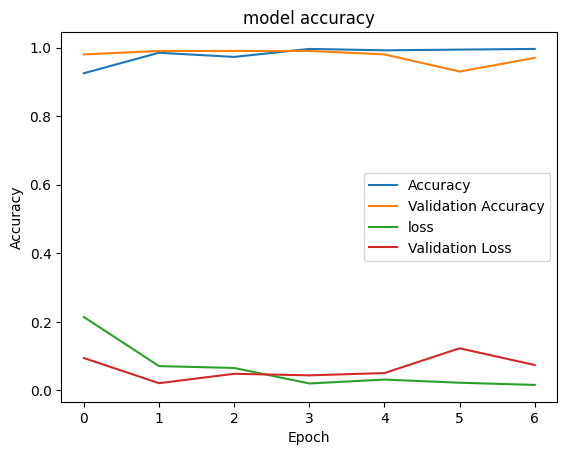

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history2.history["accuracy"])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Conclusion:

### We have got 99% acuracy and 97% validation accuracy on Xception Model

## ResNet50 Model

In [ ]:
# Load the EfficientNetB0 model pre-trained on ImageNet
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(150,150,3))

In [ ]:
# Freeze the base model layers (optional, can be fine-tuned later)
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
model = keras.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

In [ ]:
#Compiling model
model.compile(optimizer = RMSprop(learning_rate = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy',
                  patience=3,
                  verbose=1,
                  factor=0.5,
                  min_lr=0.000001)

In [ ]:
history = model.fit_generator(train_generator,
                    epochs = 10,
                    steps_per_epoch = 50,
                    validation_data = validation_generator,
                    validation_steps = 12,
                    callbacks = [early_stopping, reduce_lr]

)

Epoch 1/10
50/50 [==============================] - 185s 4s/step - loss: 0.2670 - accuracy: 0.8815 - val_loss: 0.0207 - val_accuracy: 1.0000 - lr: 2.0000e-05
Epoch 2/10
50/50 [==============================] - 183s 4s/step - loss: 0.0906 - accuracy: 0.9737 - val_loss: 0.0160 - val_accuracy: 0.9958 - lr: 2.0000e-05
Epoch 3/10
50/50 [==============================] - 190s 4s/step - loss: 0.0516 - accuracy: 0.9797 - val_loss: 0.0252 - val_accuracy: 0.9958 - lr: 2.0000e-05
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9899
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
50/50 [==============================] - 183s 4s/step - loss: 0.0340 - accuracy: 0.9899 - val_loss: 0.0213 - val_accuracy: 0.9958 - lr: 2.0000e-05
Epoch 5/10
50/50 [==============================] - 184s 4s/step - loss: 0.0191 - accuracy: 0.9929 - val_loss: 0.0316 - val_accuracy: 0.9917 - lr: 1.0000e-05
Epoch 6/10
50/50 [==============================] -

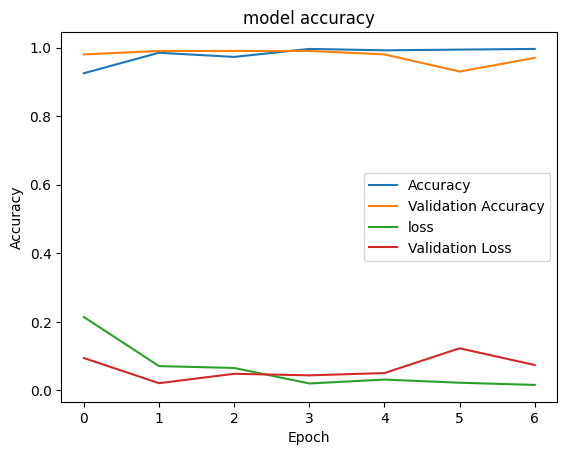

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Conclusion:

### We have got 99% acuracy and 99% validation accuracy ResNet50 Model

## vgg16 Model

In [ ]:
vgg16_base = VGG16(include_top = False,
                   weights="imagenet",
                   input_shape=(150,150,3)
                  )
vgg16_base.trainable = False #Base is not trainable in this case

58889256/58889256 [==============================] - 1s 0us/step


In [ ]:
#Creating Model
model2 = keras.Sequential([
    vgg16_base,
    layers.Flatten(),
    layers.Dropout(0.25),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

#Compiling model
model2.compile(optimizer = RMSprop(learning_rate = 2e-5),
             loss = 'binary_crossentropy',
             metrics = ['binary_accuracy'])

#Fit model
history2 = model.fit_generator(train_generator,
                    epochs = 10,
                    steps_per_epoch = 50,
                    validation_data = validation_generator,
                    validation_steps = 12,
                    callbacks = [early_stopping, reduce_lr]

)

Epoch 1/10
50/50 [==============================] - 179s 4s/step - loss: 0.0449 - accuracy: 0.9858 - val_loss: 0.0338 - val_accuracy: 0.9917 - lr: 5.0000e-06
Epoch 2/10
50/50 [==============================] - 180s 4s/step - loss: 0.0406 - accuracy: 0.9818 - val_loss: 0.0339 - val_accuracy: 0.9917 - lr: 5.0000e-06
Epoch 3/10
50/50 [==============================] - 181s 4s/step - loss: 0.0437 - accuracy: 0.9858 - val_loss: 0.0355 - val_accuracy: 0.9917 - lr: 5.0000e-06
Epoch 4/10
50/50 [==============================] - ETA: 0s - loss: 0.0368 - accuracy: 0.9848
Epoch 4: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-06.
50/50 [==============================] - 177s 4s/step - loss: 0.0368 - accuracy: 0.9848 - val_loss: 0.0377 - val_accuracy: 0.9875 - lr: 5.0000e-06
Epoch 5/10
50/50 [==============================] - 178s 4s/step - loss: 0.0239 - accuracy: 0.9949 - val_loss: 0.0171 - val_accuracy: 0.9917 - lr: 2.5000e-06
Epoch 6/10
50/50 [==============================] -

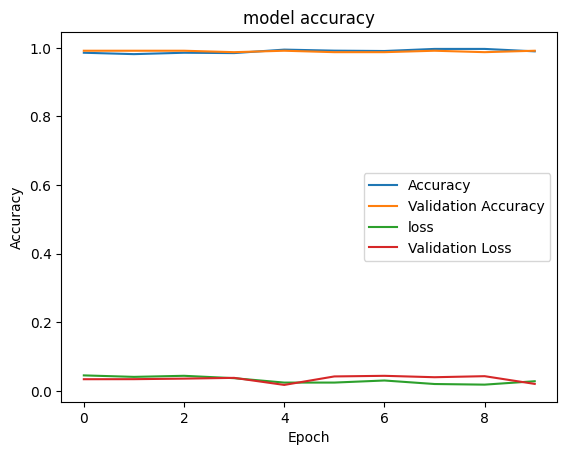

In [ ]:
plt.plot(history2.history["accuracy"])
plt.plot(history2.history['val_accuracy'])
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

## Conclusion:

### We have got 98% acuracy and 99% validation accuracy VGG16 Model

## VGG19 Model

In [ ]:
# Path for train, validation and test datasets
train_path = '//content//drive//MyDrive//horse-or-human//train'
valid_path = '//content//drive//MyDrive//horse-or-human//validation'

IMAGE_SIZE = [224, 224] #Default image size for VGG16

folders = glob('//content//drive//MyDrive//horse-or-human//train/*') #Get number of classes

# ImageDataGenerator can help perform augumentation on existing images. This way, we get more diverse train set.
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
validation_datagen = ImageDataGenerator(rescale = 1./255)

#Through flow_from_directory - we create an array of images that can be used for training.
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

validation_set = validation_datagen.flow_from_directory(valid_path,
                                                 target_size = (224, 224),
                                                 batch_size = 64,
                                                 class_mode = 'categorical')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
# Use this line for VGG19 network. Create a VGG19 model, and removing the last layer that is classifying 1000 images. This will be replaced with images classes we have.
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

# This sets the base that the layers are not trainable. If we'd want to train the layers with custom data, these two lines can be ommitted.
for layer in vgg.layers:
  layer.trainable = False

x = Flatten()(vgg.output) #Output obtained on vgg16 is now flattened.
prediction = Dense(len(folders), activation='softmax')(x) # We have 5 classes, and so, the prediction is being done on len(folders) - 5 classes

#Creating model object
model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
#Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(training_set, validation_data=validation_set, epochs=10, batch_size=32)

Epoch 1/10
17/17 [==============================] - 25s 1s/step - loss: 0.2295 - accuracy: 0.9026 - val_loss: 0.0324 - val_accuracy: 0.9883
Epoch 2/10
17/17 [==============================] - 24s 1s/step - loss: 0.0463 - accuracy: 0.9815 - val_loss: 0.0866 - val_accuracy: 0.9688
Epoch 3/10
17/17 [==============================] - 25s 1s/step - loss: 0.0113 - accuracy: 0.9971 - val_loss: 0.0958 - val_accuracy: 0.9648
Epoch 4/10
17/17 [==============================] - 24s 1s/step - loss: 0.0114 - accuracy: 0.9951 - val_loss: 0.0474 - val_accuracy: 0.9805
Epoch 5/10
17/17 [==============================] - 25s 1s/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0305 - val_accuracy: 0.9883
Epoch 6/10
17/17 [==============================] - 26s 2s/step - loss: 0.0059 - accuracy: 0.9990 - val_loss: 0.0399 - val_accuracy: 0.9844
Epoch 7/10
17/17 [==============================] - 25s 1s/step - loss: 0.0055 - accuracy: 1.0000 - val_loss: 0.0368 - val_accuracy: 0.9844
Epoch 8/10
17/17 [==

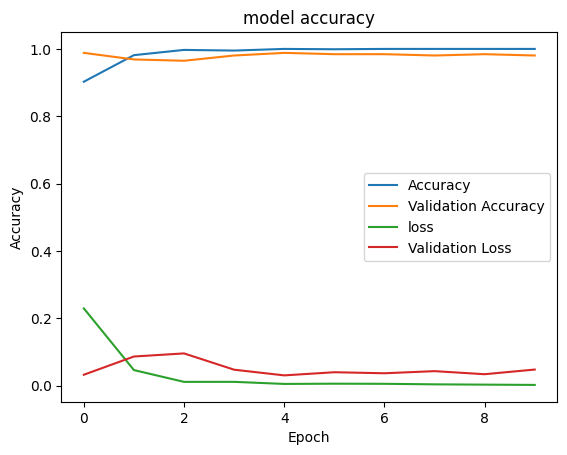

In [ ]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

### We have got 100% acuracy and 98% validation accuracy VGG19 Model

## Transfer Learning

In [4]:
# Download the inception v3 weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

# Create an instance of the inception model from the local pre-trained weights
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3),
                                include_top = False,
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

# Make all the layers in the pre-trained model non-trainable
for layer in pre_trained_model.layers:
    layer.trainable = False

# Print the model summary
pre_trained_model.summary()

--2024-06-08 15:55:48--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.137.207, 142.250.141.207, 142.251.2.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.137.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   122MB/s    in 0.7s    

2024-06-08 15:55:49 (122 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []  

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [6]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.999):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [7]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)
# Add a final sigmoid layer for classification
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001),
              loss = 'binary_crossentropy',
              metrics =['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 74, 74, 32)           864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 74, 74, 32)           96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 74, 74, 32)           0         ['batch_normalization[0][0

In [8]:
train_dir = '//content//drive//MyDrive//horse-or-human//train'
validation_dir = '//content//drive//MyDrive//horse-or-human//validation'

train_horses_dir = os.path.join(train_dir, 'horses')
train_humans_dir =os.path.join(train_dir, 'humans')
validation_horses_dir = os.path.join(validation_dir, 'horses')
validation_humans_dir =os.path.join(validation_dir, 'humans')

train_horses_fnames = os.listdir(train_horses_dir)
train_humans_fnames = os.listdir(train_humans_dir)
validation_horses_fnames = os.listdir(validation_horses_dir)
validation_humans_fnames = os.listdir(validation_humans_dir)

In [9]:
# Define our example directories and files
train_dir = '//content//drive//MyDrive//horse-or-human//train'
validation_dir = '//content//drive//MyDrive//horse-or-human//validation'

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale = 1./255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (150, 150))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary',
                                                          target_size = (150, 150))

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [10]:
callbacks =myCallback()

In [11]:
history = model.fit_generator(train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 1027 // 20,
            epochs = 5,
            validation_steps = 256 // 20,
            verbose = 2,
            callbacks = [callbacks])

Epoch 1/5
51/51 - 369s - loss: 0.8887 - accuracy: 0.9374 - val_loss: 0.0164 - val_accuracy: 1.0000 - 369s/epoch - 7s/step
Epoch 2/5
51/51 - 91s - loss: 0.1450 - accuracy: 0.9722 - val_loss: 7.9018e-05 - val_accuracy: 1.0000 - 91s/epoch - 2s/step
Epoch 3/5
51/51 - 92s - loss: 0.0539 - accuracy: 0.9851 - val_loss: 3.8766e-04 - val_accuracy: 1.0000 - 92s/epoch - 2s/step
Epoch 4/5
51/51 - 121s - loss: 0.0696 - accuracy: 0.9861 - val_loss: 0.1709 - val_accuracy: 0.9708 - 121s/epoch - 2s/step
Epoch 5/5
51/51 - 92s - loss: 0.0514 - accuracy: 0.9911 - val_loss: 0.0782 - val_accuracy: 0.9833 - 92s/epoch - 2s/step


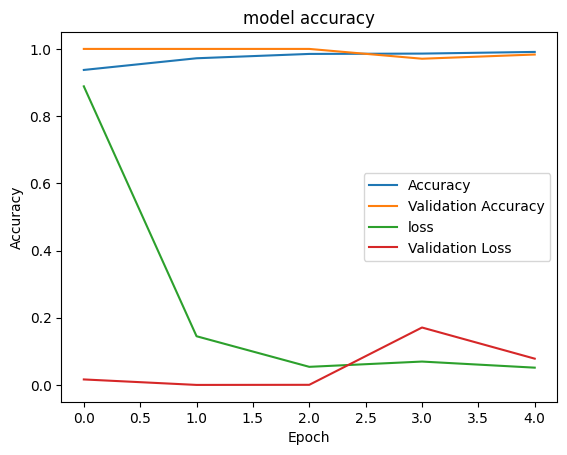

In [13]:
plt.plot(history.history["accuracy"])
plt.plot(history.history['val_accuracy'])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","loss","Validation Loss"])
plt.show()

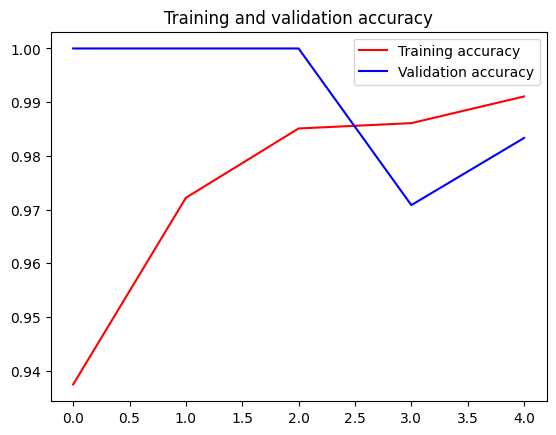

<Figure size 640x480 with 0 Axes>

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

### because over heatting and time consumming, For transfer learning i gave only 5 epoch to train and get the accuracy

### We have got 99% acuracy and 98% validation accuracy transfer learning Model

## I have used five model get find best accuracy and i have found best accuracy on all models,

### Xception:- train: 99%, validation: 97%
### ResNet50:- train: 99, validation: 99
### vgg16:- train: 98, validation: 99
### vgg19:- train: 100, validation: 98
### Transfer learning:- Learning: 99, validation: 98